In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import seaborn as sns
import numpy as np
import arviz as az
import scipy as sp
import seaborn as sns
import warnings
import matplotlib as mpl
#from statsmodels import datasets
#from theano import shared, tensor as tt
#import janitor

%matplotlib inline
warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("default")

In [3]:
def std_code(df, mu, std):
    df_coded = (df -mu)/(1*std) 
    return df_coded

def std_decode(df_coded, mu, std):
    df_decoded = (df_coded*std)+mu 
    return df_decoded
    

# Creating the dataframe with nonburnished specimens

In [4]:
df_nonburn = pd.read_csv('./df_2mm_nonburn.csv')
df_nonburn

,direction,Nf,log_Nf,log_Nf_scaled
0,RD,59203,4.772344,0.653781
1,RD,67077,4.826574,1.289613
2,RD,49434,4.694026,-0.264478
3,RD,60779,4.783754,0.787558
4,RD,49569,4.695210,-0.250591
5,RD,55114,4.741262,0.289354
6,TD,39457,4.596124,-1.412352
7,TD,39323,4.594647,-1.429674
8,TD,45393,4.656989,-0.698727
9,TD,47342,4.675247,-0.484659


In [5]:
df_nonburn.groupby('direction')['log_Nf_scaled'].agg(['mean', 'std'])

,mean,std
direction,,
RD,0.417540,0.613387
TD,-1.006353,0.486770


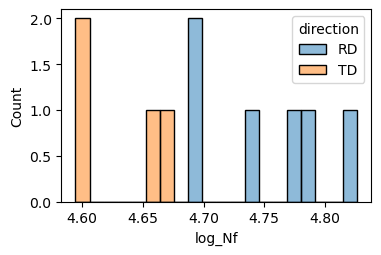

In [6]:
plt.figure(figsize=(4,2.5))
ax = sns.histplot( data = df_nonburn, x = 'log_Nf', hue = 'direction', bins =20)

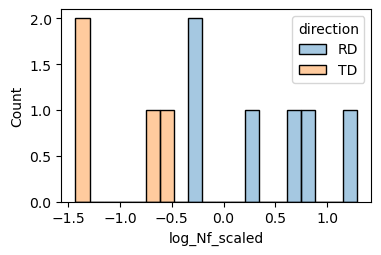

In [7]:
plt.figure(figsize=(4,2.5))
ax1 = sns.histplot( data = df_nonburn, x = 'log_Nf_scaled', hue = 'direction', bins =20, alpha =0.4)

# Preparing the Data for the A/B test

In [8]:
df_grouped = df_nonburn.groupby('direction')

In [9]:
RD_data =df_grouped.log_Nf_scaled.get_group('RD')
TD_data = df_grouped.log_Nf_scaled.get_group('TD')
par_mu = df_grouped.log_Nf_scaled.get_group('RD').agg(['mean', 'std'])
tr_mu = df_grouped.log_Nf_scaled.get_group('TD').agg(['mean', 'std'])


# Baesyan A/B Testing

In [10]:
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [21]:
with pm.Model() as BayesAB_model:
    
    #prior
    mu = pm.Normal("mu", mu= [0.5, -1], sd= 5 , shape=2)
    sdev = pm.Uniform ('sdev', 1/1000, 3, shape = 2)
    nu =pm.Exponential('nu_deg_o_fr',1/29.0)+1.0
    
    #data
    rd_data = pm.Data("rd_data", RD_data)
    trd_data = pm.Data("trd_data", TD_data)
    
    #likelihood
    rd = pm.StudentT('rd',nu=nu,  mu = mu[0], sd = sdev[0], observed = rd_data )
    trd = pm.StudentT('trd', nu=nu, mu = mu[1], sd = sdev[1], observed = trd_data)
    
    #Deterministic
    mean_diff = pm.Deterministic('Difference of Means',mu[1]-mu[0])
    scale_diff = pm.Deterministic('difference of scales', sdev[1]-sdev[0])
    effect_size = pm.Deterministic ('Effect_Size',(mu[1]-mu[0]) / np.sqrt((sdev[0]**2+ sdev[1]**2)/2))
    normality = pm.Deterministic('normality', np.log10(nu))
    
    #Prior predictive
    prior_checks = pm.sample_prior_predictive(samples=150, random_seed=23)

## Prior predictive check

In [22]:
import scipy.stats as ss

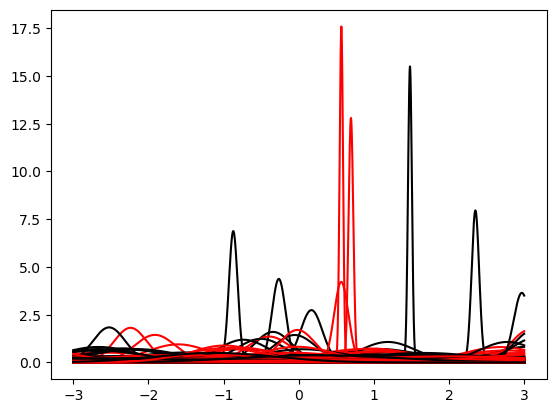

In [23]:
x = np.linspace(-3, 3, 5000)

for mrd, mtrd, srd, strd in zip(prior_checks["mu"].T[0], prior_checks["mu"].T[1],prior_checks["sdev"].T[0], prior_checks["sdev"].T[1] ):
    rd_pdf = ss.norm.pdf(x, mrd, srd) # the normal pdf
    trd_pdf = ss.norm.pdf(x, mtrd, strd,) # the normal cdf
    plt.plot(x, rd_pdf, c='r',label='rd_pdf')
    plt.plot(x, trd_pdf,c='k',label='trd_pdf')

#plt.legend();

# Sampling the model

In [284]:
with BayesAB_model:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    samples = pm.sample(22000 ,
                           tune=1000, # burn-in 1k iterations + 4k samples
                           start=start, 
                           step=step,
                           random_seed=124, cores=2, 
                           chains=2)

C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_deg_o_fr, sdev, mu]


Sampling 2 chains for 1_000 tune and 22_000 draw iterations (2_000 + 44_000 draws total) took 1018 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [285]:
pm.save_trace(samples)

'.pymc_7.trace'

In [24]:
with BayesAB_model:
   samples2 = pm.load_trace('.pymc_7.trace')

In [25]:
samples2.varnames

['mu',
 'sdev_interval__',
 'nu_deg_o_fr_log__',
 'sdev',
 'nu_deg_o_fr',
 'Difference of Means',
 'difference of scales',
 'Effect_Size',
 'normality']

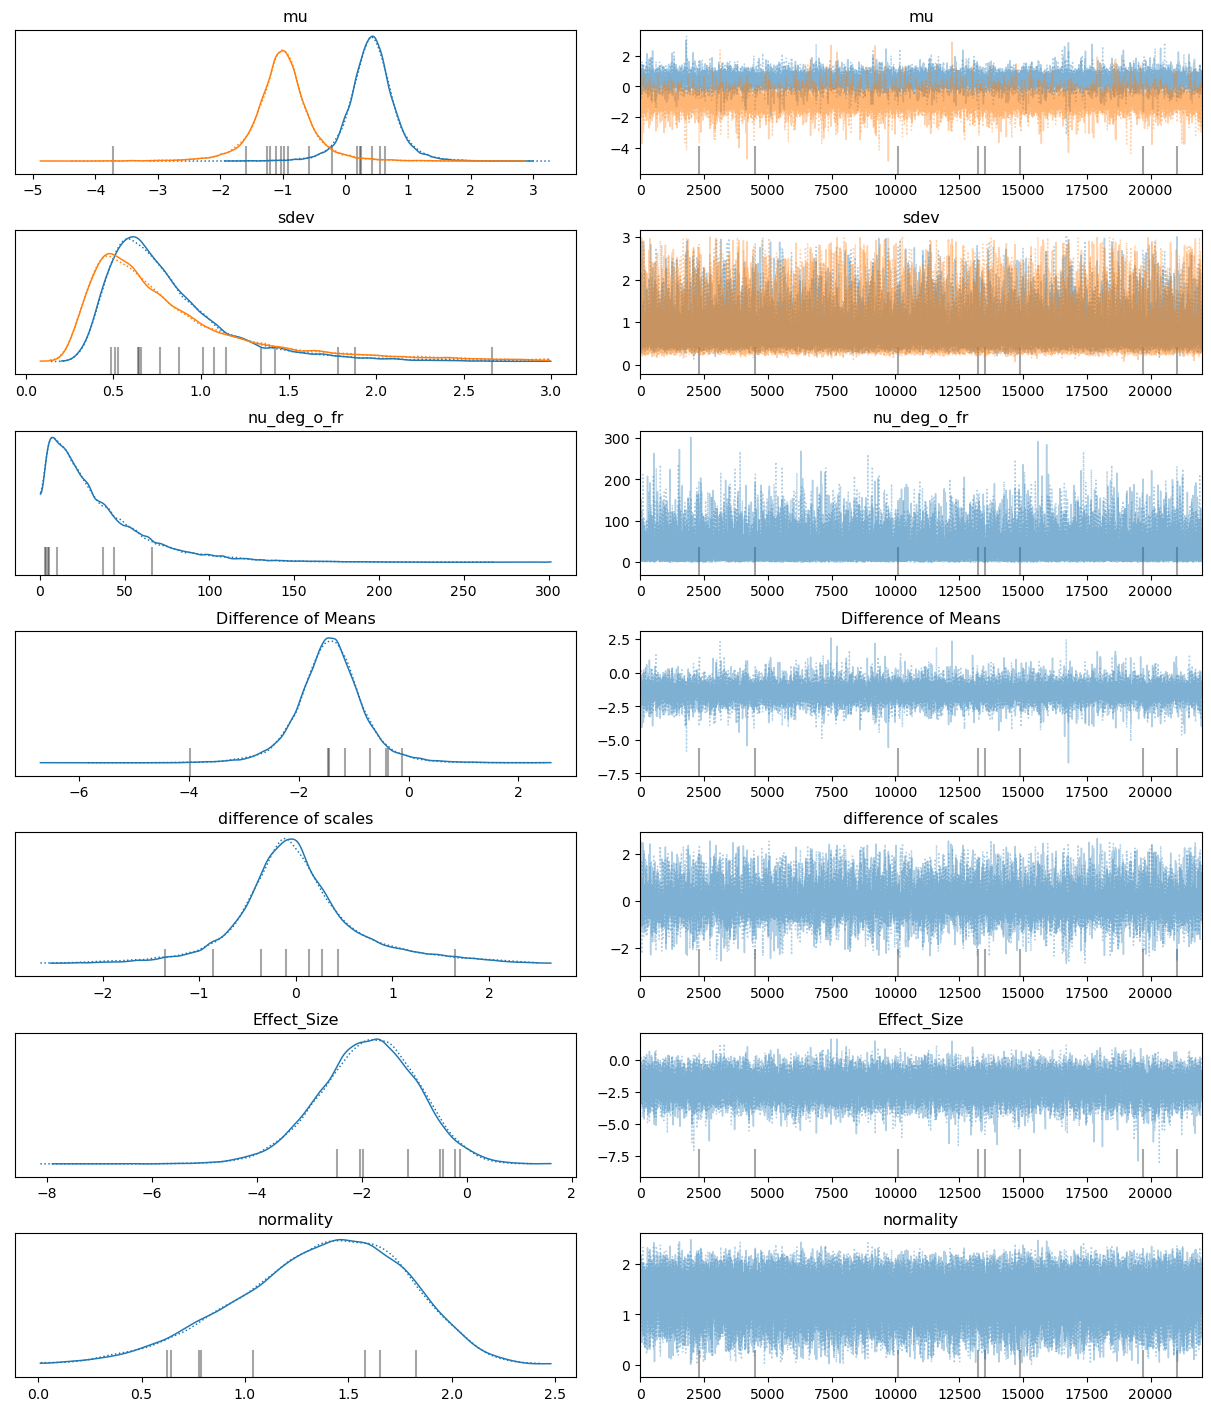

In [18]:
az.plot_trace(samples2)
plt.show()

In [26]:
pm.summary(samples2, hdi_prob =0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.418,0.379,-0.344,1.191,0.003,0.002,18848.0,14023.0,1.0
mu[1],-1.015,0.480,-2.025,-0.043,0.005,0.003,12775.0,10205.0,1.0
sdev[0],0.824,0.382,0.292,1.602,0.004,0.003,15500.0,10478.0,1.0
sdev[1],0.837,0.507,0.220,1.979,0.006,0.004,10572.0,8679.0,1.0
nu_deg_o_fr,32.962,29.786,0.020,92.087,0.147,0.117,43598.0,29349.0,1.0
Difference of Means,-1.434,0.611,-2.675,-0.174,0.006,0.004,13164.0,12837.0,1.0
difference of scales,0.013,0.634,-1.237,1.537,0.007,0.005,9206.0,9412.0,1.0
Effect_Size,-1.884,0.935,-3.723,-0.086,0.008,0.006,12567.0,11454.0,1.0
normality,1.369,0.401,0.569,2.099,0.002,0.001,43598.0,29349.0,1.0


In [33]:
plt.style.use(['arviz-white','arviz-redish'])

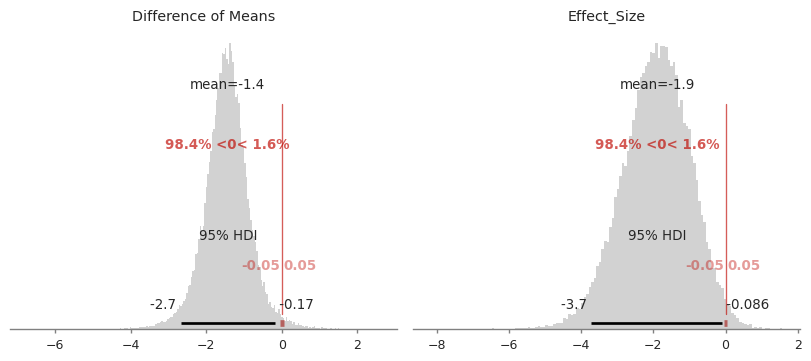

In [49]:


#mpl.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 2, figsize=(8,3.5), constrained_layout = True)

az.plot_posterior(samples2, var_names=['Difference of Means', 'Effect_Size'], textsize=9,
                         hdi_prob= 0.95, kind ='hist', 
                         ref_val =0, rope =(-0.05,0.05), 
                         color = ['gray'],filter_vars = 'redex', ax =axes);

#plt.savefig('fig7ab_hist1.png', bbox_inches ='tight', dpi = 300)


In [26]:
samples2['mu'].mean(axis=0)

array([ 0.41832647, -1.01524656])

# Posterior Predictive Check

In [29]:
repl =5
sampl =1000

In [30]:
ppc = pm.sample_posterior_predictive(samples2,
                                     model=BayesAB_model, samples=sampl, size=repl,  random_seed=124, 
                                        progressbar= True)

C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [31]:
TRD_ppc = ppc['trd'][:,0:3,:].reshape(1000,12)
RD_ppc = ppc['rd'][:,0:2,:].reshape(1000,12)

pos_mean_diff_ppc = ((RD_ppc.mean(1) - TRD_ppc.mean(1)) >0).sum()
print ('pos_mean_diff_ppc = {} %' .format(pos_mean_diff_ppc/10))

pos_mean_diff_ppc = 96.5 %


Text(0.7, 0.6, '0.39 ')

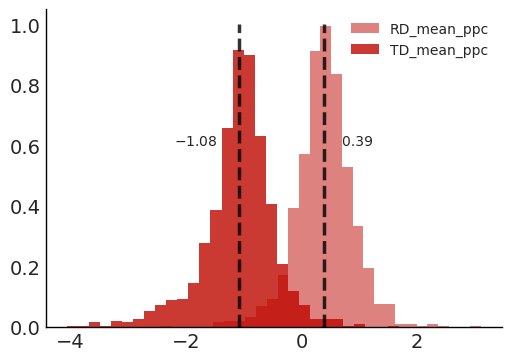

In [65]:
fig, ax =plt.subplots( figsize=(5, 3.5))
ax.hist(RD_ppc.mean(1), bins =30,density=True, alpha =0.5 , label = 'RD_mean_ppc')
ax.plot((RD_ppc.mean(1).mean(),RD_ppc.mean(1).mean()) , (0,1), '--',lw =2.5, c ='k', alpha =0.8 )

ax.hist(TRD_ppc.mean(1), bins =30,density=True, alpha =0.8,  label = 'TD_mean_ppc' )
ax.plot((TRD_ppc.mean(1).mean(),TRD_ppc.mean(1).mean()) , (0,1), '--',lw =2.5, c ='k', alpha =0.8 )
plt.legend(loc ='best', facecolor = 'white', fontsize =10)

ax.text(-2.2, 0.6, f'${TRD_ppc.mean(1).mean().round(2)} $')
ax.text(0.7, 0.6, f'{RD_ppc.mean(1).mean().round(2)} ')


In [66]:
TRD_ppc_sort = np.apply_along_axis(np.sort, axis=1, arr=TRD_ppc)
TRD_ppc_sort[1]

array([-1.88944617, -1.67482047, -1.57379582, -1.47780295, -1.41582493,
       -1.38187449, -1.14156328, -1.10172247, -1.05204007, -1.00619921,
       -0.60605525, -0.24127025])

In [67]:
RD_ppc_sort = np.apply_along_axis(np.sort, axis=1, arr=RD_ppc)
RD_ppc_sort[1]

array([-1.78970515, -1.10325454, -0.731661  ,  0.19159007,  0.52765878,
        0.6307503 ,  0.9168713 ,  1.45542481,  1.79402832,  1.87451103,
        1.9125869 ,  3.67015701])

In [68]:
idx = np.array([0,1,1,1,1,1,0,1,1,1,1,0], dtype = bool )
idx

array([False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False])

In [69]:
TRD_ppc9 = TRD_ppc_sort[:,idx]
RD_ppc9 = RD_ppc_sort[:,idx]

pos_mean_diff_ppc = ((RD_ppc9.mean(1) - TRD_ppc9.mean(1)) >0).sum()
print ('pos_mean_diff_ppc = {} %' .format(pos_mean_diff_ppc/10))

pos_mean_diff_ppc = 96.7 %


In [70]:
#muc = (df_nonburn.log_Nf.sum()+ 4.846238)/11
#stdc = np.sqrt(((df_nonburn.log_Nf**2 -muc**2).sum()+(4.846238**2-muc**2)) /10)
#print ([muc, stdc])

In [71]:
muc , stdc = (4.716582993658872, 0.08528960228608361)


In [72]:
TRD_ppc9_decode = std_decode(TRD_ppc9, muc, stdc)
RD_ppc9_decode = std_decode(RD_ppc9, muc, stdc)

# Burnished specimens

In [74]:
df_burnished = pd.read_csv('./df_2mm_burnished.csv', index_col=[0])
df_burnished.head()

,specimen_No,force_kg,feed_mm_min,cycles_to_failure,rolling_direction,burnished_regime,HV10,amp_stress_main,log_cycles
0,1010,-1,-1,154320,RD,1,336.0,238.6,5.188
1,1020,-1,0,121711,RD,2,NaN,238.6,5.085
2,1030,-1,1,109638,RD,3,NaN,238.6,5.040
3,1040,0,-1,169126,RD,4,401.0,238.6,5.228
4,1050,0,0,220720,RD,5,NaN,238.6,5.344


In [75]:
df_burnished_gr = df_burnished.groupby(['rolling_direction','burnished_regime' ]).agg(log_Nf_m =('log_cycles', np.mean))
df_burnished_gr

log_Nf_m
rolling_direction burnished_regime          
RD                1                 5.188000
                  2                 5.085000
                  3                 5.040000
                  4                 5.228000
                  5                 5.217667
                  6                 5.177000
                  7                 5.291000
                  8                 5.207000
                  9                 5.284000
TD                1                 5.117000
                  2                 5.093667
                  3                 5.087000
                  4                 5.178000
                  5                 5.151667
                  6                 5.193000
                  7                 5.362000
                  8                 5.407000
                  9                 5.192333

In [77]:
df_b_rd = df_burnished_gr.loc['RD'].sort_values('log_Nf_m', ascending=True)
rd_burn_idx =df_b_rd.index
df_b_rd

,log_Nf_m
burnished_regime,
3,5.040000
2,5.085000
6,5.177000
1,5.188000
8,5.207000
5,5.217667
4,5.228000
9,5.284000
7,5.291000


In [79]:
df_b_trd = df_burnished_gr.loc['TD'].sort_values('log_Nf_m', ascending=True)
trd_burn_idx =df_b_trd.index
df_b_trd

,log_Nf_m
burnished_regime,
3,5.087000
2,5.093667
1,5.117000
5,5.151667
4,5.178000
9,5.192333
6,5.193000
7,5.362000
8,5.407000


In [80]:
rd_burn_idx

Int64Index([3, 2, 6, 1, 8, 5, 4, 9, 7], dtype='int64', name='burnished_regime')

In [81]:
trd_burn_idx

Int64Index([3, 2, 1, 5, 4, 9, 6, 7, 8], dtype='int64', name='burnished_regime')

In [82]:
rd_gain = df_b_rd.values.T - RD_ppc9_decode
trd_gain = df_b_trd.values.T - TRD_ppc9_decode

In [83]:
Force = [-1,-1,-1,0,0,0,1,1,1]
feedrate = [-1,0,1,-1,0,1,-1,0,1]

In [85]:
new_columns=['direction','regime','Force','feedrate', 'Gfl_dB']

In [86]:

gain_df = pd.DataFrame( columns =new_columns)
gain_df

,direction,regime,Force,feedrate,Gfl_dB


In [87]:
for idx, rg in enumerate (rd_burn_idx):
    rg

In [88]:
rg-1

6

In [89]:

for idx, rg in enumerate (rd_burn_idx):
    dictrd = {'direction': 'RD',
              'regime': rg,
              'Force': Force[(rg-1)],
              'feedrate': feedrate[(rg-1)],
              'Gfl_dB': rd_gain[:,idx]*20 
              }
    gain_df = gain_df.append(pd.DataFrame(dictrd), ignore_index=True)
    print(idx)
    
    

0
1
2
3
4
5
6
7
8


In [90]:
gain_df.shape

(9000, 5)

In [91]:
for idx, rg in enumerate (trd_burn_idx):
    dictrd = {'direction': 'TD',
              'regime': rg,
              'Force': Force[(rg-1)],
              'feedrate': feedrate[(rg-1)],
              'Gfl_dB': trd_gain[:,idx]*20 
              }
    gain_df = gain_df.append(pd.DataFrame(dictrd), ignore_index=True)
    

In [92]:
gain_df.shape

(18000, 5)

In [93]:
#gain_df.to_csv('./gain_df.csv', index =False)

In [94]:
df_gr= gain_df.groupby(['direction','Force','feedrate'])['direction','Gfl_dB'].agg(['mean', 'std'])
df_gr

Gfl_dB          
                               mean       std
direction Force feedrate                     
RD        -1    -1         9.218792  0.958654
                 0         7.895118  1.091355
                 1         7.484699  1.321574
           0    -1         8.767560  0.942651
                 0         8.885500  0.908589
                 1         9.328641  1.009343
           1    -1         9.135435  1.210823
                 0         9.285541  0.918864
                 1         9.511895  1.039165
TD        -1    -1        10.715018  1.360518
                 0        10.675796  1.555568
                 1        11.087695  1.863726
           0    -1        11.225821  1.154396
                 0        11.048576  1.222720
                 1        10.532329  1.150782
           1    -1        13.513529  1.260023
                 0        13.861914  1.503352
                 1        10.858759  1.115719

(5.0, 15.0)

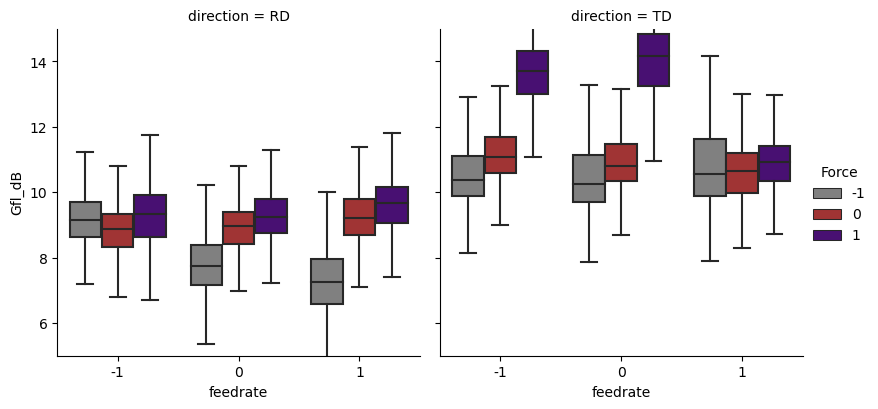

In [95]:
plt.style.use(['default'])

colors=['gray','firebrick','indigo']
sns.catplot(x="feedrate", y="Gfl_dB",
                hue="Force", col="direction",
                data=gain_df, kind="box", showfliers = False, palette =colors,
                height=4, aspect=1);
plt.ylim([5,15])

C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\data\base.py:169: UserWarning: More chains (1000) than draws (9). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


<Figure size 800x350 with 0 Axes>

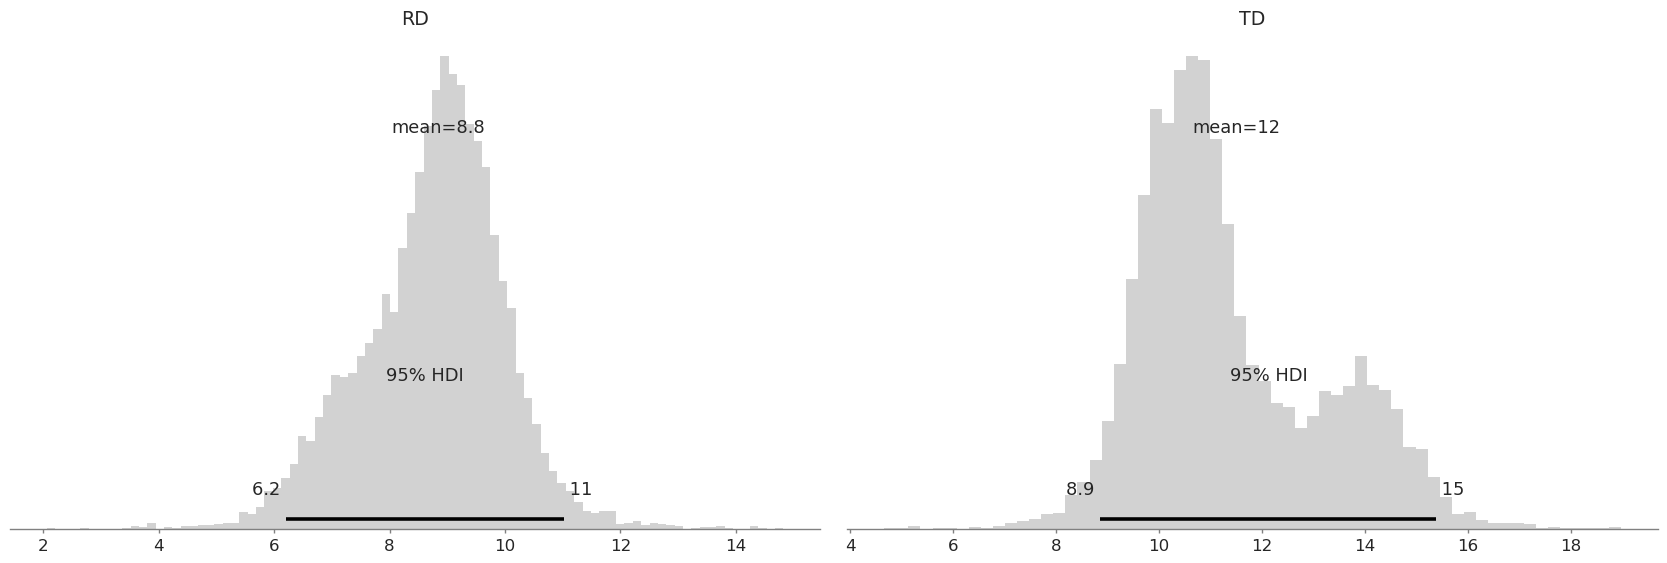

In [49]:
plt.figure(2, figsize=(8,3.5))
axes = az.plot_posterior(gain_dict, var_names=['RD','TD'], textsize=12,
                         hdi_prob= 0.95, kind ='hist', 
                         #ref_val =0, rope =(-0.1,0.1), 
                         color = ['gray'],filter_vars = 'redex');
#plt.xticks(size=10, weight = 'bold', color = '0.2')
#plt.savefig('fig7ab_box.png', bbox_inches ='tight', dpi = 300)